# Ще тествам https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline/notebook, за да видя дали се справя по-добре от моите модели досега

Интересното е, че този модел се води Naive Bayes, но при моят pipeline използващ MultinomialNaiveBayes, се справи много по-зле.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [6]:
lens = train["comment_text"].str.len()
lens.mean(), lens.std(), lens.max()

(394.07322132467681, 590.72028190489186, 5000)

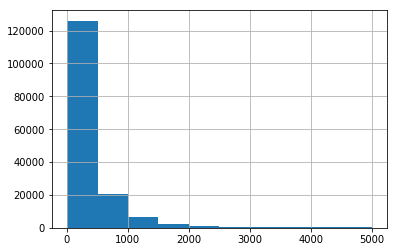

In [7]:
%matplotlib inline
lens.hist()

Стана ми интересно, колко чара са изрченията, а в тест сета?

In [10]:
lens = test["comment_text"].str.len()
lens.mean(), lens.std(), lens.max()

(364.87512078556318, 592.49209873027792, 5000)

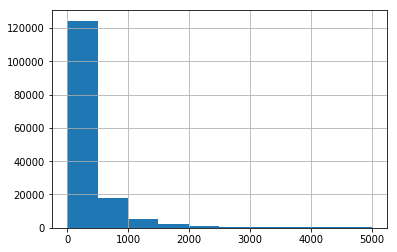

In [11]:
%matplotlib inline
lens.hist()

Изглеждат еднакво, което е добре (т.е дистрибуцията е що годе еднаква)

In [8]:
train["comment_text"] = train["comment_text"].fillna("unknown")
test["comment_text"] = test["comment_text"].fillna("unknown")

In [21]:
n = train.shape[0]

TODO: да седна да разбера тия уравнения

In [12]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [13]:
def get_mdl(train, y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = train.multiply(r)
    return m.fit(x_nb, y), r

In [14]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
label_cols = train.drop(["id", "comment_text"], axis=1).columns

In [15]:
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

corpus = train["comment_text"].append(test["comment_text"])
vec.fit(corpus)


In [31]:
x = vec.transform(train["comment_text"])

In [53]:
test_x = vec.transform(test["comment_text"])

fit toxic


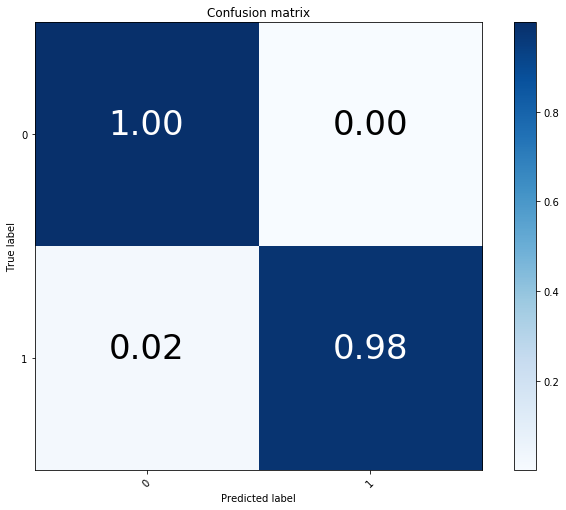

fit severe_toxic


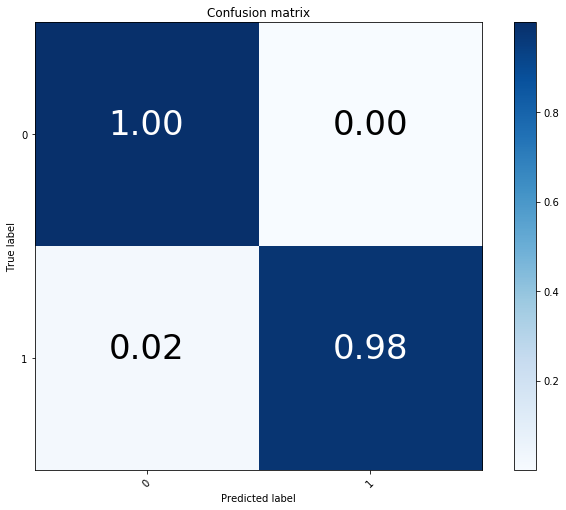

fit obscene


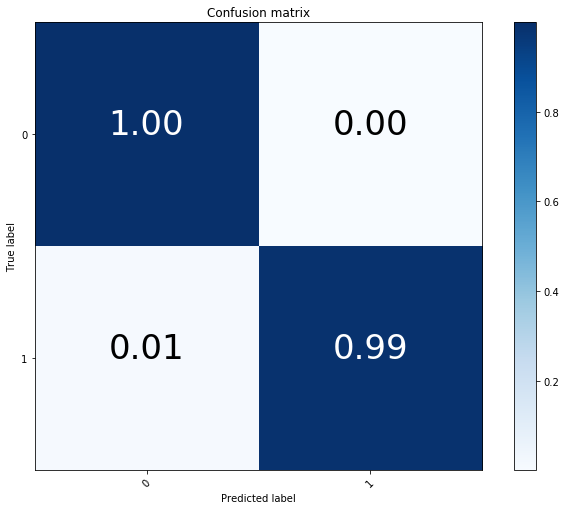

fit threat


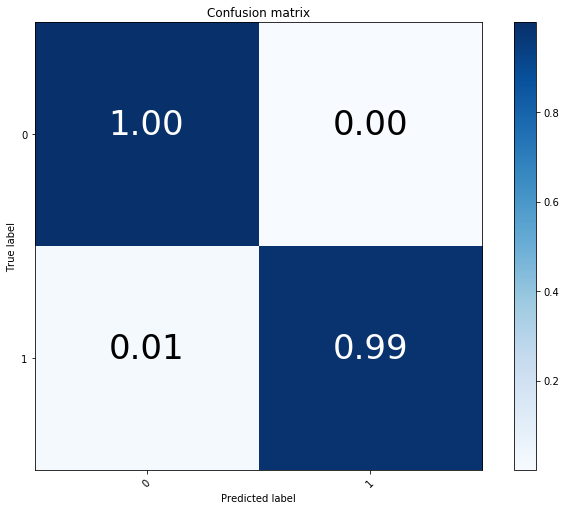

fit insult


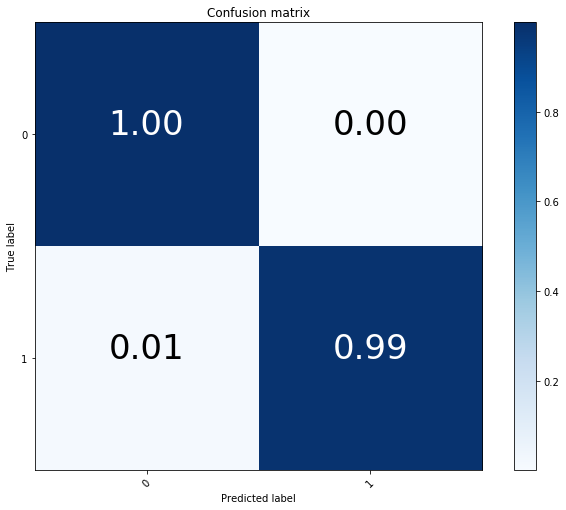

fit identity_hate


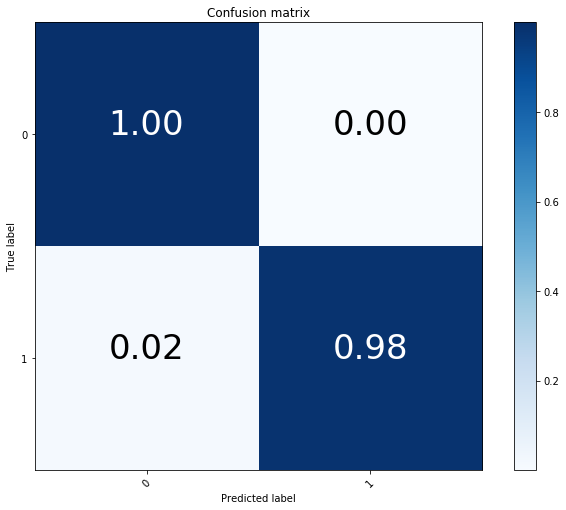

In [54]:

preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(x, train[j])
    plot_confusion_matrix(train[j],m.predict(x.multiply(r)), classes=[0,1], normalize=True)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    

Хмм това е научило train set-а много добре, я да пробваме със сплит?

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [51]:
vec = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

corpus = train["comment_text"].append(test["comment_text"])
vec.fit(corpus)
x = vec.transform(train["comment_text"])

fit toxic
Train count: 119678
0    108232
1     11446
Name: toxic, dtype: int64
Test count: 39893
0    36045
1     3848
Name: toxic, dtype: int64
ROC on train 0.977889074901
ROC on test 0.622279222466


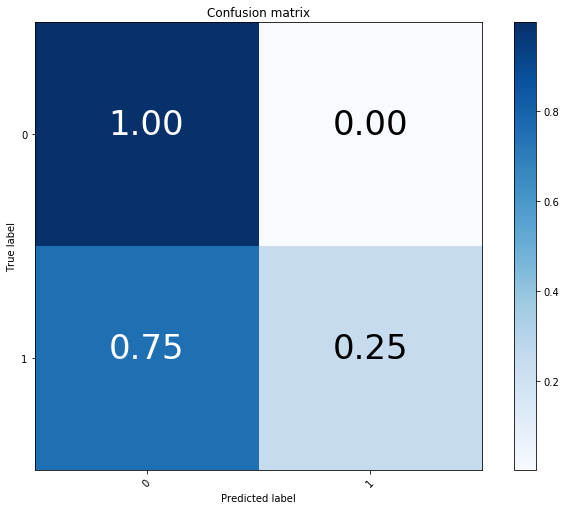

fit severe_toxic
Train count: 119678
0    118498
1      1180
Name: severe_toxic, dtype: int64
Test count: 39893
0    39478
1      415
Name: severe_toxic, dtype: int64
ROC on train 0.987241721308
ROC on test 0.570451073253


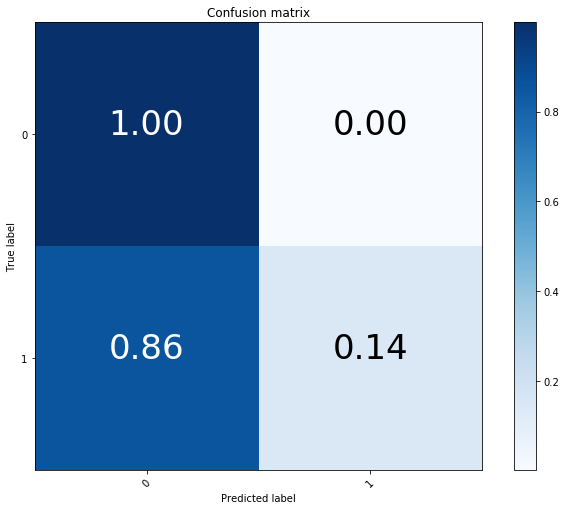

fit obscene
Train count: 119678
0    113343
1      6335
Name: obscene, dtype: int64
Test count: 39893
0    37779
1     2114
Name: obscene, dtype: int64
ROC on train 0.988910573747
ROC on test 0.64140643502


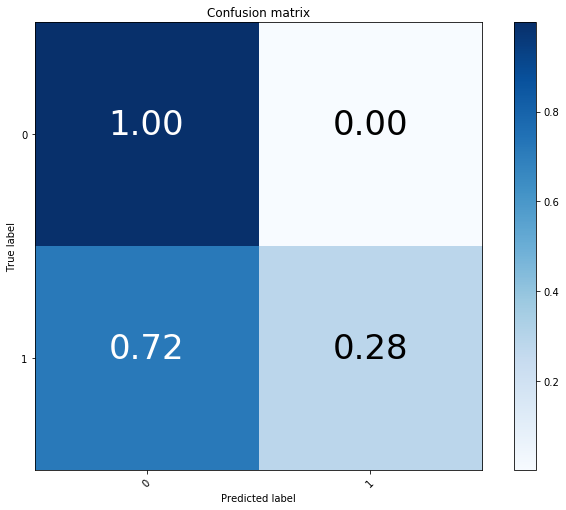

fit threat
Train count: 119678
0    119310
1       368
Name: threat, dtype: int64
Test count: 39893
0    39783
1      110
Name: threat, dtype: int64
ROC on train 0.993198140212
ROC on test 0.59537913636


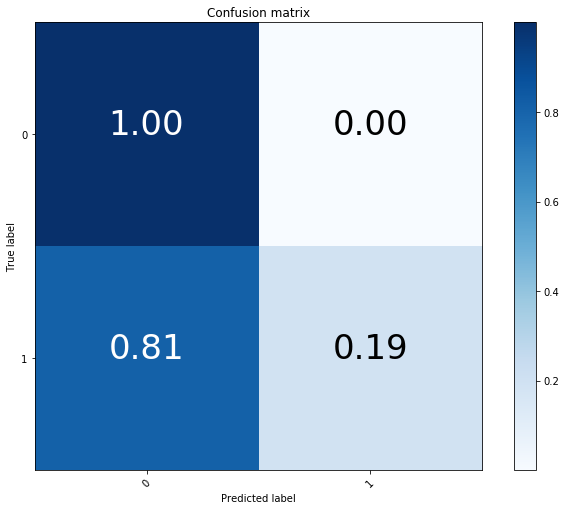

fit insult
Train count: 119678
0    113776
1      5902
Name: insult, dtype: int64
Test count: 39893
0    37918
1     1975
Name: insult, dtype: int64
ROC on train 0.988203577382
ROC on test 0.61444349933


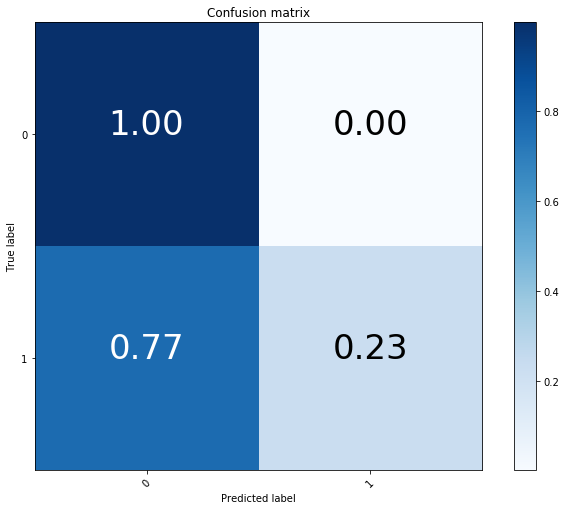

fit identity_hate
Train count: 119678
0    118634
1      1044
Name: identity_hate, dtype: int64
Test count: 39893
0    39532
1      361
Name: identity_hate, dtype: int64
ROC on train 0.992332950108
ROC on test 0.55237861932


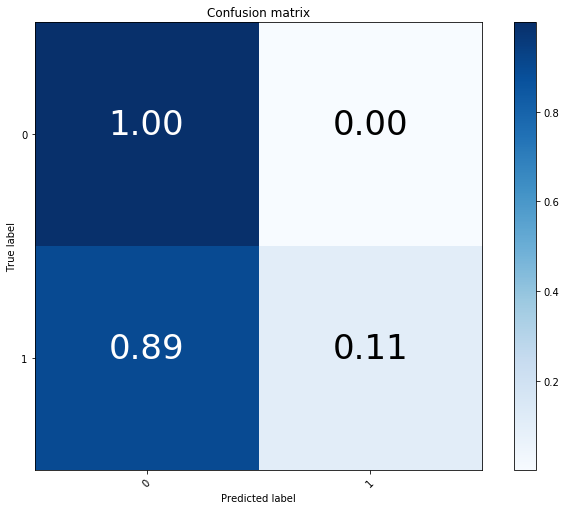

In [52]:
roc_train = []
roc_test = []
for i, j in enumerate(label_cols):
    print('fit', j)
    train_x, train_test_x, train_y, train_test_y = train_test_split(x, train[j], random_state=0)
    print("Train count:",train_x.shape[0])
    print(train_y.value_counts())
    print("Test count:",train_test_x.shape[0])
    print(train_test_y.value_counts())
    m,r = get_mdl(train_x, train_y)
    predicted_train = m.predict(train_x.multiply(r))
    predicted = m.predict(train_test_x.multiply(r))
    roc_train_score = roc_auc_score(train_y, predicted_train)
    roc_train.append(roc_train_score)
    print("ROC on train", roc_train_score)
    roc_test_score = roc_auc_score(train_test_y, predicted)
    roc_test.append(roc_test_score)
    print("ROC on test", roc_test_score)
    plot_confusion_matrix(train_test_y, predicted, classes=[0,1], normalize=True)

In [43]:
roc_train = np.array(roc_train)
roc_test = np.array(roc_test)

roc_train.mean(), roc_test.mean()

(0.9754662785462388, 0.61630872222983346)

Изглежда доста зле на тест.. или имам бъг :?

In [19]:
submission = pd.DataFrame(data=preds,columns=label_cols,index=test["id"] )
submission[:5]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.999991,0.058964,0.999925,0.002262,0.991233,0.144967
0000247867823ef7,0.001914,0.000307,0.000961,0.000107,0.002143,0.000362
00013b17ad220c46,0.007025,0.000406,0.002119,0.000137,0.002645,0.000441
00017563c3f7919a,0.001196,0.000221,0.001154,0.000160,0.001072,0.000274
00017695ad8997eb,0.008618,0.000494,0.001897,0.000134,0.002281,0.000364


Разликата между биграми и триграми :)

In [55]:
submission = pd.DataFrame(data=preds,columns=label_cols,index=test["id"] )
submission[:5]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.999985,0.061408,0.999895,0.001339,0.988638,0.071981
0000247867823ef7,0.003266,0.000326,0.001323,0.000119,0.002215,0.000380
00013b17ad220c46,0.005715,0.000396,0.001970,0.000145,0.002331,0.000442
00017563c3f7919a,0.001434,0.000276,0.001199,0.000152,0.001248,0.000327
00017695ad8997eb,0.007147,0.000456,0.001859,0.000141,0.002098,0.000394


In [56]:
submission.to_csv("./submission_tf_nb.csv")

Mда даде висок резултат, когато го събмитнах в kaggle